# REALIZAMOS LAS IMPORTACIONES

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# VERIFICAMOS SI HAY UNA GPU DISPONIBLE

In [3]:
"""
Se usa para determinar si una GPU está disponible en el sistema y, en base a eso, asignar el dispositivo adecuado para ejecutar los cálculos en PyTorch.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
torch.cuda.is_available() Esta función verifica si CUDA (tecnología de computación en GPU de NVIDIA) está disponible en el sistema.
torch.device() Crea un objeto de tipo torch.device, que indica en qué dispositivo (CPU o GPU) deben ejecutarse los tensores y los cálculos.
"""
"""
¿Por qué es útil?
✅ Portabilidad: Permite escribir código que se ejecuta tanto en CPU como en GPU sin modificaciones.
✅ Rendimiento: Si hay una GPU disponible, los cálculos se ejecutarán en ella, lo que acelera el entrenamiento de modelos de IA.
✅ Buena práctica: Es una forma estándar en PyTorch de manejar dispositivos de manera eficiente.
"""

# Transformaciones: convertir a tensor y normalizar imágenes

In [4]:
"""
Se usa para preprocesar imágenes antes de ingresarlas a un modelo en PyTorch,especialmente en redes neuronales profundas.
"""
"""
transforms.ToTensor()

Convierte una imagen PIL o un numpy.ndarray en un tensor de PyTorch.
Escala automáticamente los valores de los píxeles de [0, 255] a [0, 1], ya que PyTorch usa números en coma flotante (float32).
2️⃣ transforms.Normalize((0.5,), (0.5,))

Normaliza la imagen para mejorar la estabilidad y el rendimiento del modelo.
Cada píxel de la imagen es transformado según la fórmula:
x_normalized = (x - mean) / std siendo std la desviación estándar.
En este caso, (0.5,) es la media y (0.5,) es la desviación estándar, lo que hace que los valores de los píxeles pasen de [0,1] a [-1,1].
"""
#https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Compose.html#torchvision.transforms.v2.Compose
#https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html#totensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
"""
¿Por qué se convierten y normalizan las imágenes?
✅ Mejora la convergencia del modelo: Los valores entre -1 y 1 permiten que la red aprenda más rápido y evitan problemas de gradientes.
✅ Reducción de variabilidad: La normalización hace que todas las imágenes tengan un rango de valores similar, lo que ayuda a la red a ser más estable.
✅ Compatible con modelos preentrenados: Muchos modelos de visión por computadora esperan imágenes normalizadas en un cierto rango.
"""

# Cargar el dataset MNIST

In [5]:
"""
Solo algunas consideraciones:
El parámetro root: Indica la ruta donde se ha de guardar el dataset
El parámetro train: Indica si la data es de entrenamiento o no; si es de entrenamiento (True) descargará 60,000 imágenes y sino descargará las imágenes de prueba (10,000).
El parámetro transform: Indica las transformaciones que sufrirá el dataset
El parámetro download: Indica si se descargará el dataset en la ruta específicada (root); si el dataset, ya existe, no será nuevamente descargado
"""
#https://pytorch.org/vision/0.9/datasets.html#mnist
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)


# Crear dataloaders


In [6]:
"""
📌 Propósito: Carga el conjunto de entrenamiento en lotes (batches) de 64 imágenes y las mezcla aleatoriamente en cada época.

train_dataset → Conjunto de datos de entrenamiento previamente cargado.
batch_size=64 → Divide los datos en lotes de 64 imágenes para cada paso del entrenamiento.
shuffle=True → Baraja las imágenes en cada época para mejorar la generalización del modelo.
"""
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
"""
Solo algunas consideraciones:

train_dataset / test_dataset: representa el parámetro del dataset que se se va a cargar

batch_size: Indica la cantidad de imágenes que existen por lote; es decir, tu dataset de 10,000 imágenes se dividirá en pequeños segmentos de 64 imágenes, estas 64 imágenes se procesan en una sola pasada por la red neuronal antes de actualizar los pesos. El 64 es un número arbitrario que puedes ir cambiando para poder mejorar el entrenamiento de tu modelo.

shuffle: Indica si los datos se barajan; esto es importante por lo siguiente; imagina que tienes una distribución de datos de 1 a 10000, si cortamos en segmentos de 64 y realizamos una media no obtendremos valores realmente representativos de los datos, esto pues la muestra no está homogenea; entonces el shuffle garantiza que los datos estén distribuidos, lo cual por defecto mejora la generalización del módelo; esto cobra especial interés cuando estamos en el proceso de entrenamiento.
"""

# Definir la arquitectura del MLP con ReLU


In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        """
        nn.Linear(28 * 28, 512):
        Es una capa densa totalmente conectada (FC - Fully Connected).
        Toma 784 entradas (28x28) → 512 neuronas ocultas.
        Cada píxel de la imagen se aplana y se usa como entrada.
        nn.ReLU():

        Función de activación ReLU (Rectified Linear Unit).
        Introduce no linealidad en la red para que pueda aprender relaciones complejas.
        nn.Dropout(0.2):

        Regularización: Desactiva aleatoriamente el 20% de las neuronas en cada iteración para evitar sobreajuste.
        """
        """
        nn.Linear(512, 256):
            Reduce el tamaño de la capa oculta de 512 a 256 neuronas.
            Mantiene conexiones densas entre las capas.
            nn.ReLU():

            Se vuelve a aplicar ReLU para introducir no linealidad.
            nn.Dropout(0.2):

            Se aplica otro Dropout del 20% para mejorar la generalización.
        """
        #https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        #RELU: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),  # Regularización
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # Capa de salida
        )
        """
        nn.Linear(128, 10):
        Capa final con 10 neuronas (una para cada dígito del 0 al 9).
        No usa ReLU aquí, porque queremos que la salida sea procesada por CrossEntropyLoss, que aplica Softmax internamente.
        """
        """
         ¿Cómo funciona Dropout?
            En cada iteración del entrenamiento, desactiva aleatoriamente un porcentaje de neuronas.
            Esto fuerza a la red a aprender representaciones más robustas, ya que no puede depender demasiado de ninguna neurona en particular.
            En la inferencia (evaluación o prueba), Dropout se desactiva automáticamente, usando todos los pesos de la red.
        """
        """
        ¿Qué es una capa densa totalmente conectada (Fully Connected - FC)?
        Una capa densa o capa totalmente conectada (FC - Fully Connected) es un tipo de capa en una red neuronal en la que cada neurona está conectada a todas las neuronas de la capa anterior y de la capa siguiente.
        📌 Características de una Capa Densa (FC)
            🔹 Cada neurona recibe entrada de todas las neuronas previas.
            🔹 Se usa en redes neuronales profundas (DNNs), redes convolucionales (CNNs) y redes recurrentes (RNNs).
            🔹 Realiza una transformación lineal:
        """

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplanar la imagen
        return self.model(x)


# Instanciar el modelo y moverlo a GPU si está disponible


In [8]:
"""
Esta línea de código crea una instancia del modelo MLP y lo mueve al dispositivo de cómputo adecuado (CPU o GPU)
"""
model = MLP().to(device)


# Cargamos nuestro modelo en caso exista


In [ ]:
# Definir nuevamente la arquitectura del modelo
#model_loaded = MLP().to(device)

# Cargar los pesos guardados
#model_loaded.load_state_dict(torch.load("mlp_mnist.pth"))

# Poner el modelo en modo evaluación
#model_loaded.eval()
print("Modelo cargado correctamente!")

# Definir función de pérdida y optimizador


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo


In [14]:
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs): # total de épocas 10
    model.train() # Indica que el modelo está en modo entrenamiento
    running_loss = 0.0 #Acumula la perdida dentro de la época actual

    for images, labels in train_loader: #recorremos las imágenes de entrenamiento
        images, labels = images.to(device), labels.to(device) # movemos los datos al cpu o gpu

        # Forward pass (Propagación hacia adelante)
        outputs = model(images) #Las imágenes se pasan a través del modelo para obtener las predicciones
        loss = criterion(outputs, labels) # Se calcula pérdida comparando las predicciones (outputs) con las etiquetas reales (labels)

        # Backward pass (Propagación hacia atrás) y Optimización
        optimizer.zero_grad() # se reinician los gradientes para evitar acumulación
        loss.backward() # Calcula los gradientes de la función de pérdida con respecto a los pesos del modelo (usando retropropagación).
        optimizer.step() # Actualiza los pesos del modelo en función de los gradientes calculados.

        running_loss += loss.item() #Acumulación de la pérdida en la época actual
    # Evaluación en el conjunto de prueba

    train_losses.append(running_loss / len(train_loader))# Se guarda la pérdida media del entrenamiento en la época.
    model.eval() #Cambia el modelo a modo de evaluación (desactiva Dropout y BatchNorm).
    correct = 0 #Indica el número de predicciones correctas
    total = 0 #Indica el número total de predicciones (muestra)
    #Iniciamos el cálculo de la precisión en el conjunto de prueba
    with torch.no_grad():#Desactiva el cálculo de gradientes (reduce el consumo de memoria y acelera la inferencia).
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) #e obtiene la predicción del modelo en las imágenes de prueba.
            _, predicted = torch.max(outputs, 1)#Se obtiene la clase con la mayor probabilidad como predicción.
            total += labels.size(0)#Se actualiza el total de imágenes procesadas.
            correct += (predicted == labels).sum().item() #Se suman las predicciones correctas.
    #Cálculo de precisión y almacenamiento de resultados
    accuracy = correct / total #Calcula la precisión en el conjunto de prueba.
    test_accuracies.append(accuracy) #Almacena la precisión en la lista de precisión en prueba.

    print(f"Época [{epoch + 1}/{num_epochs}], Pérdida: {train_losses[-1]:.4f}, Precisión en prueba: {accuracy:.4f}")


Época [1/10], Pérdida: 0.0802, Precisión en prueba: 0.9771
Época [2/10], Pérdida: 0.0767, Precisión en prueba: 0.9779
Época [3/10], Pérdida: 0.0727, Precisión en prueba: 0.9778
Época [4/10], Pérdida: 0.0713, Precisión en prueba: 0.9803
Época [5/10], Pérdida: 0.0670, Precisión en prueba: 0.9780
Época [6/10], Pérdida: 0.0621, Precisión en prueba: 0.9821
Época [7/10], Pérdida: 0.0658, Precisión en prueba: 0.9809
Época [8/10], Pérdida: 0.0617, Precisión en prueba: 0.9772
Época [9/10], Pérdida: 0.0606, Precisión en prueba: 0.9828
Época [10/10], Pérdida: 0.0580, Precisión en prueba: 0.9829


# Guardar el modelo entrenado


In [15]:
torch.save(model.state_dict(), "mlp_mnist.pth")
print("Modelo guardado exitosamente!")

Modelo guardado exitosamente!


# Graficar la evolución de la pérdida y la precisión


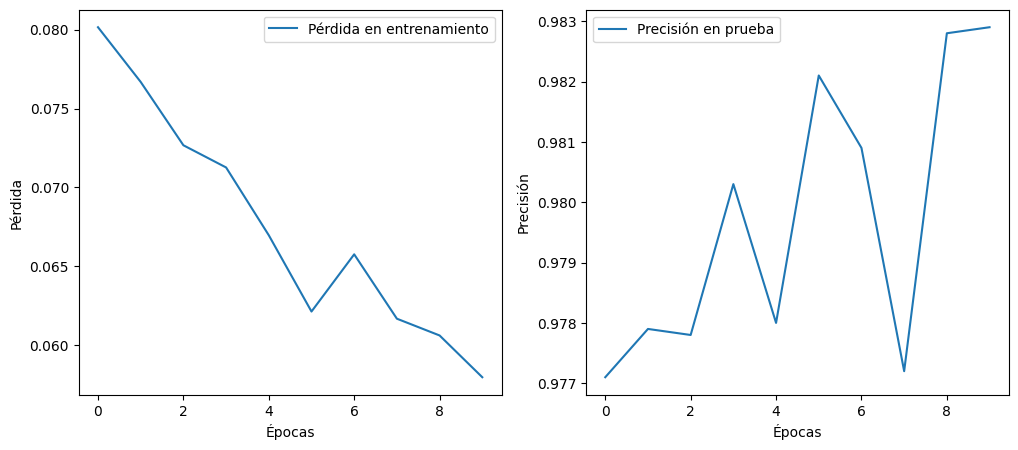

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Pérdida en entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Precisión en prueba")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

plt.show()

# Función para predecir un dígito con el modelo entrenado


In [18]:
def predict_digit(model, image_tensor):
    model.eval()  # Poner el modelo en modo evaluación

    # Si la imagen ya es un tensor, solo aseguramos que tenga la forma correcta
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Agregar batch dimension

    # Obtener la predicción
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    return predicted_label.item()

# Obtener una imagen de prueba del conjunto MNIST


In [19]:
test_sample, label = test_dataset[0]  # Selecciona la primera imagen del dataset


# Predecir el dígito


In [20]:
predicted_digit = predict_digit(model, test_sample)


# Mostrar la imagen y la predicción


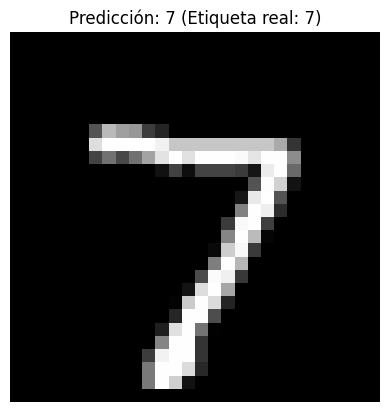

In [21]:
plt.imshow(test_sample.squeeze(), cmap="gray")
plt.title(f"Predicción: {predicted_digit} (Etiqueta real: {label})")
plt.axis("off")
plt.show()